<a href="https://colab.research.google.com/github/pleunipennings/CSC508_ML_Biomedicine_Class/blob/main/Module6/Module_6b_Gradient_Boosted_Tree_Antibiotic_resistance_dataset_CSC508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Welcome to the module 6b coding part: Grading Boosted Tree!**

*This notebook was created at San Francisco State University (SFSU) for the Promoting INclusivity and Computing (PINC) and gSTAR programs by Dr. Pleuni Pennings (SFSU biology professor), Lucy Moctezuma Tan (California State University, East Bay CSUEB master student) and Lorena Benitez-Rivera (SFSU master students). All members of the COde to understand Drug resistance Evolution (CODE) lab in 2023.*

#OBJECTIVE OF THIS NOTEBOOK:

In this notebook we will learn how to create a **Gradient Boosted Tree** model using different functions that will allow us to get predicted labels for each type of drug instead of doing it one drug at a time.

The objective of this notebook is to learn how to apply what we have been learning in a more complex project, so you can think of different ways in which machine learning could be used. In this case we will try to recreate specifically some of the results from the **Gradient Boosted Tree** model that was used in [Moragadivand's 2018 paper](https://doi.org/10.1371/journal.pcbi.1006258).

In this notebook you will learn:

- How to create different functions that will let us run our **Gradient Boosted Tree** model per drug and per feature combinations.
- How to link all functions together to create a cohesive workflow and get our results.    

## **Step 1) Importing packages needed**
Just like before we will be loading up the previous packages and functions we have seen so far.

In [20]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import packages for Gradient Boosted Tree model
from xgboost import XGBClassifier
from sklearn import preprocessing

# Imports for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imports for data visualization
import matplotlib.pyplot as plt

# Imports for file management
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Step 2) Loading CSV file and creating dataframes for each antibiotic**

#### **a) Loading CSV created from previous notebook (6a)**

Let's first load our merged dataframe, created by notebook 6a, containing each feature and labels for all our drugs. The datataframe contains:

1.   **Year features as a matrix**
2.   **Population structure features**
3.   **Presence and absence of specific genes**

We will learn in the following steps how to select different combinations of these 3 features.

In [21]:
# Loads csv file as a dataframe
filepath= '/content/drive/MyDrive/EColi_ML_CSV_files/'
# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-21-36e031182889>:4: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")


,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


#### **b) Creating dataframes for each drug**

Below we will be creating the function **makeDF**, this will allow us to create one dataframe for each antibiotic drug, by joining the labels of one group and the features corresponding to it.

In [22]:
# creating a list of antibiotic names
drug_list = All_Drugs_df.iloc[:,1:13].columns
drug_list

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

In [23]:
# creating a function that makes dataframes for each antibiotic and dropping NaN values
def makeDF(drug):
  df_list = [All_Drugs_df[["Isolate",drug]],All_Drugs_df.iloc[:,13:]]
  Drug_df = pd.concat(df_list, axis=1)
  Drug_df = Drug_df.dropna()
  return Drug_df

Below we will demonstrate how **makeDF** works by creating a single dataframe using the the drug AMP that contains the labels for AMP and all the features we are interested in.

In [24]:
# implementing function using as example the drug AMP
AMP_df = makeDF("AMP")

# looking at the shape of AMP dataframe
print("AMP dataframe shape: ", AMP_df.shape)

# looking at the first 5 rows of this dataframe
AMP_df.head()

AMP dataframe shape:  (841, 18293)


,Isolate,AMP,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Step 3) Separating each drug dataframe into sections**

The dataframe will be separated into 4 sections:

1.   **Training features**
2.   **Training labels**
3.   **Testing features**
4.   **Testing labels**








#### **a) Creating testing and training datasets for each antibiotic drug**
Below we will be creating the function **Split_train_test**, which will allow us to split the dataset of each of the dataframes created by our previous function, and store these splits into a single python dictionary. Then we will test this function by splitting only the dataframe we created before using the drug AMP.

In [25]:
# Separating each dataframe into Labels and Features
def Split_train_test(Drug_df,drug):
  Train_test_dic = {}
  labels = Drug_df[drug]
  features = Drug_df.drop(columns=[drug])
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

## Task 1:
Below we implement the function we just created and accessed specifically the training features of the AMP dataset. Try accessing the other three key-value pairs of this dictionary, such as the features of the testing dataset.
What do you think are some of the benefits of using a dictionary to store the different parts of the dataset?

I think it's important to have the key-value pairs organized like this as it helps with training as each value is indexed properly and can be used properly to train a model, whatever the model might be.

In [26]:
# Implementing the function Split_train_test() for AMP example
AMP_Train_test_dic = Split_train_test(AMP_df,"AMP")
AMP_Train_test_dic["features_train"]

,Isolate,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,Year_2003.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
755,11658_8#26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1837,24742_1#282,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,18090_8#7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1520,18090_6#44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1684,24742_1#103,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,11657_7#7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,11658_4#24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761,11658_8#32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1530,18090_6#54,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
AMP_Train_test_dic["labels_test"]

1580    R
1912    S
100     R
1646    R
382     S
       ..
1438    R
1427    R
192     R
1201    R
1866    R
Name: AMP, Length: 278, dtype: object

In [28]:
AMP_Train_test_dic["labels_train"]

755     R
1837    R
1678    R
1520    R
1684    S
       ..
266     R
392     S
761     R
1530    R
388     S
Name: AMP, Length: 563, dtype: object

In [29]:
# Access the features testing of the dictionary

Below you can also access all the Python dictionary elements we have created for this specific AMP dataset. Below I decided to print the shape for each of the data chunks we have split.

In [30]:
# checking the shape of each dataframe or series stored in the dictionary created for drug AMP
print("AMP")
for k, df in AMP_Train_test_dic.items():
  print(k, df.shape)

AMP
labels_train (563,)
features_train (563, 18292)
labels_test (278,)
features_test (278, 18292)


## **Step 4) Creating different combination of features before training**
Below we will be creating the function **combo_feat**, which will allow us to choose what are the specific combinations we want to use to train our model. As you can see we have decided to test all the ones present in the **combo_list** list.

In [31]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['G','S', 'GS', 'GYS']

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, drug, combo):

  # creating Year column filters for features_df
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Population structure column filters for features_df
  pop_str_filter = [col for col in features_df if col.startswith("cutoff")]
  pop_struc_feat = features_df[pop_str_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in pop_str_filter and col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'S':
    df_list = [features_df['Isolate'], pop_struc_feat]
    S_feat_df = pd.concat(df_list, axis=1)
    S_feat_df = S_feat_df.drop(columns=['Isolate'])
    return S_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

  if combo== "GS":
    df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat]
    GS_feat_df = pd.concat(df_list, axis=1)
    GS_feat_df = GS_feat_df.drop(columns=['Isolate'])
    return GS_feat_df

  if combo == 'SY':
    df_list = [features_df['Isolate'], pop_struc_feat, year_feat]
    SY_feat_df = pd.concat(df_list, axis=1)
    SY_feat_df = SY_feat_df.drop(columns=['Isolate'])
    return SY_feat_df

  if combo == 'GYS':
    df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat, year_feat]
    GYS_feat_df = pd.concat(df_list, axis=1)
    GYS_feat_df = GYS_feat_df.drop(columns=['Isolate'])
    return GYS_feat_df


Following the example of working with a single drug AMP, we can see below that we can actually test and access a specific part of the dictionary we created in the previous step and also choose specifically what feature combination we are interested in training. In this case is **GS (Gene Presence and Absence and Population Structure)**

In [32]:
# Implementing combo_feat() function created for training data
AMP_GS_train_df = combo_feat(AMP_Train_test_dic['features_train'],"AMP","GS")

# looking only at the feature column names for the combination for "GS" for drug "AMP" for training data
AMP_GS_train_df.columns

Index(['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR',
       'galM',
       ...
       'cutoff_25459', 'cutoff_25654', 'cutoff_25772', 'cutoff_25979',
       'cutoff_26792', 'cutoff_27119', 'cutoff_27236', 'cutoff_27248',
       'cutoff_27690', 'cutoff_45092'],
      dtype='object', length=18269)

## **Step 5) Creating Gradient Boosted Trees model and training it per feature combination**

Below we will create  another function called **run_GB** that will let us create and train our Gradient Boosted Tree, by assigning a training data (features, labels and what feature combination) we would like to train.

In [33]:
# creating Gradient Boosted Trees model function
def run_GB(feat_train_df, lab_train, drug, combo):
  labels = lab_train
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  print(drug +" Training combo: "+ combo)
  GB =  XGBClassifier(random_state = 42)
  GB = GB.fit(feat_train_df, labels_t)
  return GB

Below we will test our function by:
- Using the **training features** we specified in the previously **(step 4)**.
- Getting our **training labels** from the python dictionary we created before **(step 3)**
- Specifying the feature combination we want, in this example, **GS**.

In [34]:
# implementing run_GB() for specific drug feature combination dataframe
GB_AMP_GS_model = run_GB(AMP_GS_train_df, AMP_Train_test_dic['labels_train'],"AMP","GS")
GB_AMP_GS_model

AMP Training combo: GS


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## **Step 6) Making predictions from Gradient Boosted Trees model**
We will create here another function called **predict** to make our predictions using:
- The model we trained on **(step 5)**
- Choosing the test features chunks we made from **(step 3)**

In [35]:
# creating a function using the model created and trained and the feature combinations from testing data
def predict(GB_combo_Model, features_test):
  labels_pred = GB_combo_Model.predict(features_test)
  return labels_pred

Below we will be resusing our function **combo_feat** to specify that we want to use only specific features from out test dataset, because it has to be based on what our model was trained with. In this case we only want **GS combination**.

In [36]:
# Implementing combo_feat() function created for testing data
AMP_GS_test_df = combo_feat(AMP_Train_test_dic['features_test'],"AMP","GS")

# looking only at the feature column names for the combination for "GS" for drug "AMP" for testing data
AMP_GS_test_df.columns

Index(['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR',
       'galM',
       ...
       'cutoff_25459', 'cutoff_25654', 'cutoff_25772', 'cutoff_25979',
       'cutoff_26792', 'cutoff_27119', 'cutoff_27236', 'cutoff_27248',
       'cutoff_27690', 'cutoff_45092'],
      dtype='object', length=18269)

Finally we will use our function with the correct model and correct testing dataset, where the only combination we want to make predictions with is GS. We will also print out how many did our model predict Resistance(R) and how many were predicted as Susceptible(S). In this case we got 210 Resistant E.Coli Predicted and 68 E.Coli Susceptible Predicted to the AMP drug, using only the feature combination GS.



In [37]:
# Implementation of the predict() function using the feature combination "GS"
AMP_GS_labels_pred = predict(GB_AMP_GS_model,AMP_GS_test_df)

# transforming back our labels for interpretation in the next output
labels_pred = np.where(AMP_GS_labels_pred<1,"R","S")

# observe how many predictions were made for each category "R" and "S"
print("Labels predicted: ", np.unique(labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype='<U1'), array([210,  68]))


## **Step 7) Evaluating our model using a confusion matrix and metrics**

Below we create our last function **evaluate**, where we are able to extract our accuracy, f-scores for Resistant and Susceptible E.Coli, plus a Confusion Matrix. Notice that within the function, we had to convert the labels test into numbers as well in order to be able to be compared with our predicted labels.

In [38]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(GB_combo_model, labels_test, labels_pred, cf= True):
  labels = labels_test
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  report = classification_report(labels_t, labels_pred, output_dict = True)
  accuracy = report['accuracy']
  R_recall = report["0"]['recall']# Resistant
  S_recall = report["1"]['recall']# Susceptible
  if cf == True:
    labels_pred = np.where(labels_pred<1,"R","S")
    cm = confusion_matrix(labels_test, labels_pred, labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp.plot()
    plt.show()
  return [accuracy,R_recall,S_recall]

Below we will be testing our function using:
- The model we trained in **(step 5)**
- The test labels we separated and put into a data dictionary in **(Step 3)**
- The predicted labels that we got from **(Step 6)**

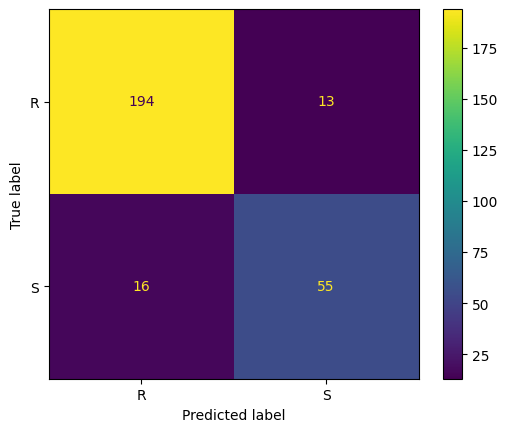

Results from Model for drug: AMP
Using feature combination: GS
Accuracy:  0.89568345323741
R_recall:  0.9371980676328503
S_recall:  0.7746478873239436


In [39]:
# implementing the evaluate() function
Model_Report = evaluate(GB_AMP_GS_model, AMP_Train_test_dic['labels_test'],AMP_GS_labels_pred)
print("Results from Model for drug: AMP")
print("Using feature combination: GS")
print("Accuracy: ", Model_Report[0])
print("R_recall: ", Model_Report[1])
print("S_recall: ", Model_Report[2])

## Task 2:
As a review, list all the functions we have created so far in this notebook. Write a one-sentence description in your own words for each of the functions. We will use those functions in step 8.

## **Step 8) Use all functions and evaluate every drug in every feature combination!**

Alright this is the part where we put all our created functions into use by creating a for loop, that chains each of the steps we have done so far.



**Complete Task 2 here**



def makeDF(drug): creates a function that makes dataframes for each antibiotic and dropping NaN values


def Split_train_test(Drug_df,drug): Separates each dataframe into Labels and Features


def combo_feat(features_df, drug, combo): makes a function that creates different feature combinations of the predictor features


def run_GB(feat_train_df, lab_train, drug, combo): creates Gradient Boosted Trees model function


def predict(GB_combo_Model, features_test): creates a function using the model created and trained and the feature combinations from testing data

def evaluate(GB_combo_model, labels_test, labels_pred, cf= True): Creates a function that evaluates our model using our actual and predicted data


#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [40]:
# let's check all drugs
drug_list

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

In [41]:
# let's see all combinations we are interested in
combo_list

['G', 'S', 'GS', 'GYS']

#### **b) Create a loop that will go through all our functions using the lists above**

Below is how we chose to chain these functions in order to get all our results and store them in a dictionary called **GB_model_metrics**. Note that this will take a long time as it is training for each drug every combination of features we have specified, so just sit back and grab something to drink as the computer does it's job.  You can check the print out to see what model it's currently training.

**Note:** This loop will take some time to run. Lucy Moctezuma who wrote the code says it took 42 minutes when she last did it.
If that is too long for you, feel free to focus on fewer of the drugs and fewer of the combintions. For example, you could loop over part of the drug_list (for drug in drug_list[:3]

In [42]:
# Lets use all our functions this time and save our report into a single data structure
GB_model_metrics = {}

for drug in drug_list:
  print(drug)
  Drug_df = makeDF(drug) # creates one df per drug
  Test_Train_dic = Split_train_test(Drug_df, drug) # splits each drug df into a dictionary with testing and training data
  for combo in combo_list:
    # Training each drug_combo features
    labels_train = Test_Train_dic["labels_train"]
    features_train = combo_feat(Test_Train_dic["features_train"], drug, combo) # create corresponding feature_df for training
    GB_combo_model = run_GB(features_train, labels_train, drug, combo) # runs gradient boosted model using the corresponding training feature_df

    # Predicting each drug_combo features
    features_test = combo_feat(Test_Train_dic["features_test"], drug, combo) # create corresponding feature_df for testing
    labels_pred = predict(GB_combo_model, features_test) # generate predictions based on the feature combination tested

    # Evaluating our models
    labels_test = Test_Train_dic["labels_test"]
    report = evaluate(GB_combo_model, labels_test, labels_pred, cf=False) #extracting the metrics we want from the models report
    GB_model_metrics[drug+"_"+combo] = report #saving these metrics into dictionary

    print(report)

CTZ
CTZ Training combo: G
[0.9561815336463224, 0.7640449438202247, 0.9872727272727273]
CTZ Training combo: S
[0.8935837245696401, 0.449438202247191, 0.9654545454545455]
CTZ Training combo: GS
[0.9514866979655712, 0.7415730337078652, 0.9854545454545455]
CTZ Training combo: GYS
[0.9499217527386542, 0.7415730337078652, 0.9836363636363636]
CTX
CTX Training combo: G
[0.9820846905537459, 0.9262295081967213, 0.9959349593495935]
CTX Training combo: S
[0.9283387622149837, 0.8114754098360656, 0.9573170731707317]
CTX Training combo: GS
[0.9771986970684039, 0.9180327868852459, 0.991869918699187]
CTX Training combo: GYS
[0.9723127035830619, 0.9180327868852459, 0.9857723577235772]
AMP
AMP Training combo: G
[0.89568345323741, 0.9516908212560387, 0.7323943661971831]
AMP Training combo: S
[0.762589928057554, 0.8888888888888888, 0.39436619718309857]
AMP Training combo: GS
[0.89568345323741, 0.9371980676328503, 0.7746478873239436]
AMP Training combo: GYS
[0.9136690647482014, 0.9565217391304348, 0.7887323

#### **c) Store the metrics report for all drugs and features combinations as a csv file**

After running our code is only necessary for us to save it as a csv file, that way we can access it later on!

In [43]:
# convert dictionary into a dataframe
GB_metrics = pd.DataFrame.from_dict(GB_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall"]).reset_index()
GB_metrics = GB_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
GB_metrics.to_csv(filepath+"GB_metrics_df.csv", index= False)
GB_metrics


,Drug_combo,Accuracy,R_recall,S_recall
0,CTZ_G,0.956182,0.764045,0.987273
1,CTZ_S,0.893584,0.449438,0.965455
2,CTZ_GS,0.951487,0.741573,0.985455
3,CTZ_GYS,0.949922,0.741573,0.983636
4,CTX_G,0.982085,0.926230,0.995935
5,CTX_S,0.928339,0.811475,0.957317
6,CTX_GS,0.977199,0.918033,0.991870
7,CTX_GYS,0.972313,0.918033,0.985772
8,AMP_G,0.895683,0.951691,0.732394
9,AMP_S,0.762590,0.888889,0.394366


#### **d) Create a bar graph showing accuracies of all drugs when using all features (GS)**

Below we will create a quick bar graph checking at how each of the drugs performed using the specific combination of GS. (Gene Absence and Presence + Population Structure)

In [44]:
# filtering for all the rows that contain GS combination only
GS_filter = [drug_combo for drug_combo in GB_metrics['Drug_combo'] if drug_combo.endswith("GS")]
GS_df = GB_metrics.loc[GB_metrics["Drug_combo"].isin(GS_filter)]


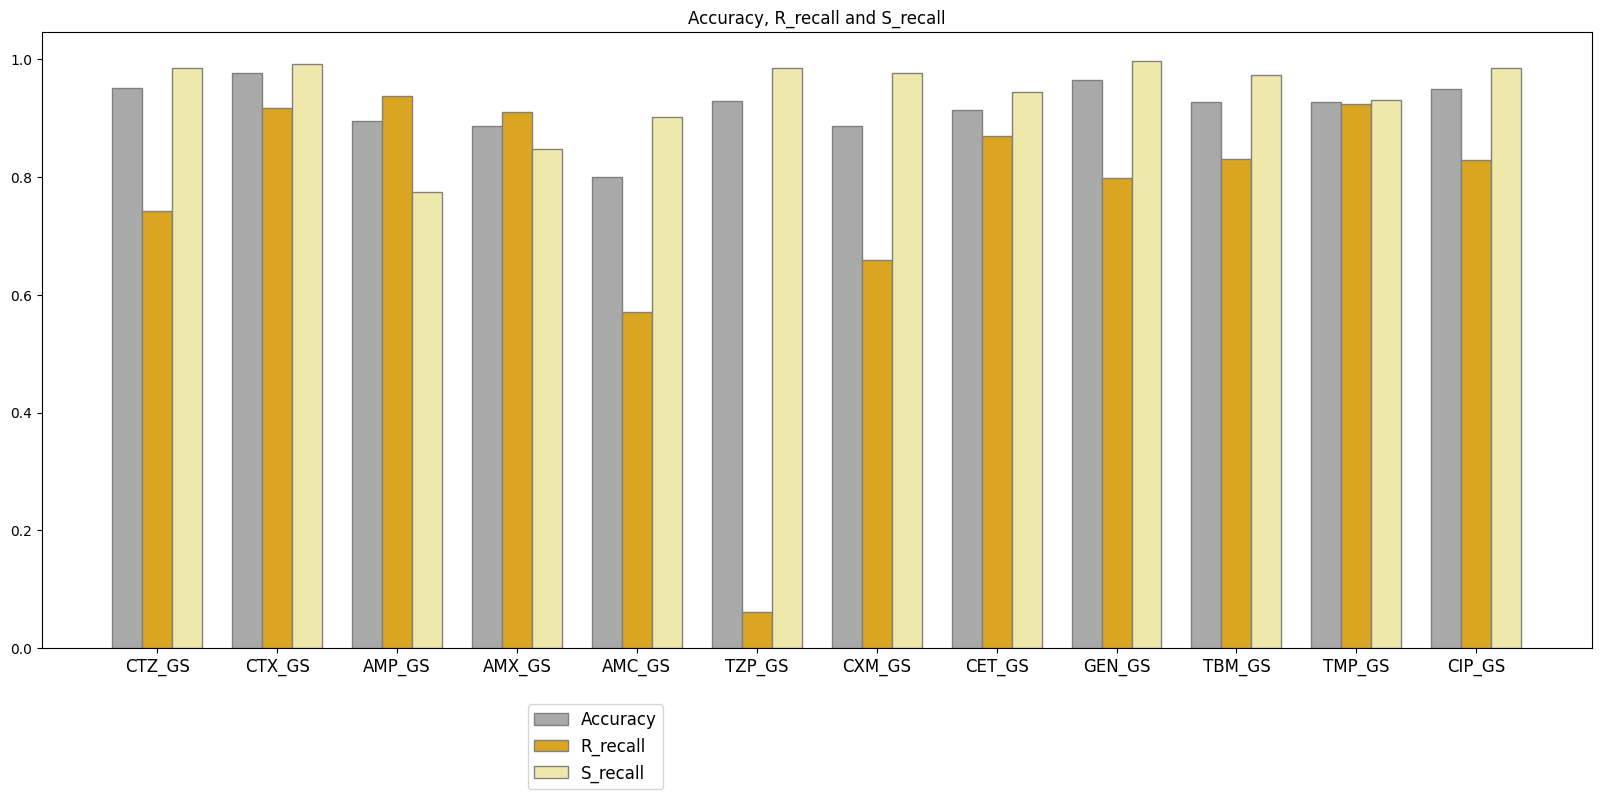

In [45]:
# plotting bar graph of only

# Figure Size
fig = plt.figure(figsize =(20, 8))

# Adding title
plt.title('Accuracy, R_recall and S_recall', fontsize = 12)

# Variables to be plotted
x = np.arange(len(GS_df["Drug_combo"]))
acc = list(GS_df["Accuracy"])
R_rec = list(GS_df["R_recall"])
S_rec = list(GS_df["S_recall"])

# Plotting barcharts
acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="darkgrey", edgecolor="gray")
r_rec_bar=plt.bar(x, height= R_rec, width=0.25, color="goldenrod", align="center", edgecolor="gray")
s_rec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="palegoldenrod", edgecolor="gray")

plt.xticks([r for r in range(len(GS_df["Drug_combo"]))],
        GS_df["Drug_combo"], fontsize = 12)

#legend
fig.legend([acc_bar,r_rec_bar,s_rec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

# Show Plot
plt.show()


## Task 3:

Looking at the Graph above and the barplots for percentage resistance you made in 6A, why do you think TZP had such a high accuracy but such low Resistance Recall Score?

**Answer your question here**

I believe that TZP has such a low resistance recall score because there was a very small amount of resistance data for TZP, also the percentage of resistance was pretty low as well.

## Task 4:

Now that you have seen how creating different functions and stringing them together allows you to tackle a more complex project. Try to challenge yourself and do the same but using a Random Forest Model!
- Feel free to use this code as a general guide.
- Create your own functions and see if you can get as an end result to recreate the final dataframe and csv file with all the results stored.
- Remember there are many ways to tackle this problem.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
def run_RF(feat_train_df, lab_train, drug, combo):
  labels = lab_train
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  print(drug +" Training combo: "+ combo)
  RF =  RandomForestClassifier(n_estimators=100, random_state=42)
  RF = RF.fit(feat_train_df, labels_t)
  return RF

In [48]:
RF_AMP_GS_model = run_RF(AMP_GS_train_df, AMP_Train_test_dic['labels_train'],"AMP","GS")

AMP Training combo: GS


In [49]:
# Lets use all our functions this time and save our report into a single data structure
RF_model_metrics = {}

for drug in drug_list:
  print(drug)
  Drug_df = makeDF(drug) # creates one df per drug
  Test_Train_dic = Split_train_test(Drug_df, drug) # splits each drug df into a dictionary with testing and training data
  for combo in combo_list:
    # Training each drug_combo features
    labels_train = Test_Train_dic["labels_train"]
    features_train = combo_feat(Test_Train_dic["features_train"], drug, combo) # create corresponding feature_df for training
    GB_combo_model = run_RF(features_train, labels_train, drug, combo) # runs gradient boosted model using the corresponding training feature_df

    # Predicting each drug_combo features
    features_test = combo_feat(Test_Train_dic["features_test"], drug, combo) # create corresponding feature_df for testing
    labels_pred = predict(GB_combo_model, features_test) # generate predictions based on the feature combination tested

    # Evaluating our models
    labels_test = Test_Train_dic["labels_test"]
    report = evaluate(GB_combo_model, labels_test, labels_pred, cf=False) #extracting the metrics we want from the models report
    RF_model_metrics[drug+"_"+combo] = report #saving these metrics into dictionary

    print(report)

CTZ
CTZ Training combo: G
[0.9061032863849765, 0.449438202247191, 0.98]
CTZ Training combo: S
[0.9076682316118936, 0.5056179775280899, 0.9727272727272728]
CTZ Training combo: GS
[0.917057902973396, 0.5056179775280899, 0.9836363636363636]
CTZ Training combo: GYS
[0.9092331768388107, 0.48314606741573035, 0.9781818181818182]
CTX
CTX Training combo: G
[0.9609120521172638, 0.8524590163934426, 0.9878048780487805]
CTX Training combo: S
[0.9381107491856677, 0.819672131147541, 0.967479674796748]
CTX Training combo: GS
[0.9495114006514658, 0.8524590163934426, 0.9735772357723578]
CTX Training combo: GYS
[0.9511400651465798, 0.8688524590163934, 0.9715447154471545]
AMP
AMP Training combo: G
[0.802158273381295, 0.9323671497584541, 0.4225352112676056]
AMP Training combo: S
[0.762589928057554, 0.9130434782608695, 0.323943661971831]
AMP Training combo: GS
[0.802158273381295, 0.9323671497584541, 0.4225352112676056]
AMP Training combo: GYS
[0.7913669064748201, 0.9420289855072463, 0.352112676056338]
AMX
A

In [50]:
# convert dictionary into a dataframe
RF_metrics = pd.DataFrame.from_dict(RF_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall"]).reset_index()
RF_metrics = RF_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
RF_metrics.to_csv(filepath+"RF_metrics_df.csv", index= False)
RF_metrics

,Drug_combo,Accuracy,R_recall,S_recall
0,CTZ_G,0.906103,0.449438,0.980000
1,CTZ_S,0.907668,0.505618,0.972727
2,CTZ_GS,0.917058,0.505618,0.983636
3,CTZ_GYS,0.909233,0.483146,0.978182
4,CTX_G,0.960912,0.852459,0.987805
5,CTX_S,0.938111,0.819672,0.967480
6,CTX_GS,0.949511,0.852459,0.973577
7,CTX_GYS,0.951140,0.868852,0.971545
8,AMP_G,0.802158,0.932367,0.422535
9,AMP_S,0.762590,0.913043,0.323944


In [51]:
RF_filter = [drug_combo for drug_combo in RF_metrics['Drug_combo'] if drug_combo.endswith("GS")]
RF_df = RF_metrics.loc[RF_metrics["Drug_combo"].isin(RF_filter)]

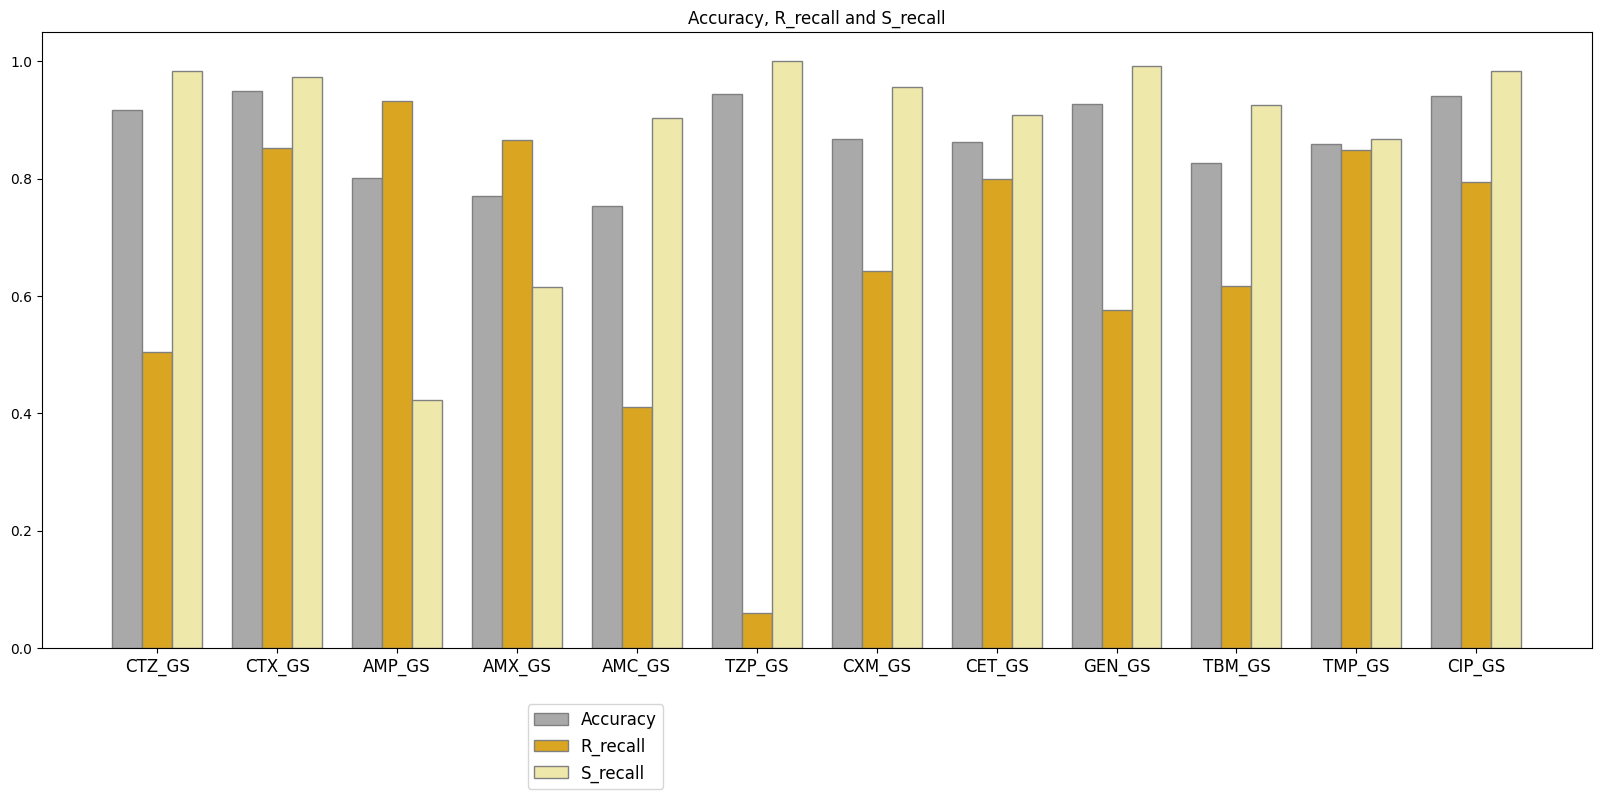

In [52]:
# Figure Size
fig = plt.figure(figsize =(20, 8))

# Adding title
plt.title('Accuracy, R_recall and S_recall', fontsize = 12)

# Variables to be plotted
x = np.arange(len(RF_df["Drug_combo"]))
acc = list(RF_df["Accuracy"])
R_rec = list(RF_df["R_recall"])
S_rec = list(RF_df["S_recall"])

# Plotting barcharts
acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="darkgrey", edgecolor="gray")
r_rec_bar=plt.bar(x, height= R_rec, width=0.25, color="goldenrod", align="center", edgecolor="gray")
s_rec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="palegoldenrod", edgecolor="gray")

plt.xticks([r for r in range(len(RF_df["Drug_combo"]))],
        RF_df["Drug_combo"], fontsize = 12)

#legend
fig.legend([acc_bar,r_rec_bar,s_rec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

# Show Plot
plt.show()
